In [1]:
import sys
from pathlib import Path

In [2]:
root_path = Path.cwd().parent 
if str(root_path) not in sys.path:
    sys.path.append(str(root_path))
root_path

PosixPath('/home/arpola/Documents/GalaxyClassifier')

In [3]:
import mlflow
from mlflow import MlflowClient
import torch
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from src.cnn_t import NeuralNet
from src.utils.general import get_data, LazyGalaxyDataset,get_splits
import torchmetrics
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import v2

/home/arpola/Documents/GalaxyClassifier/.venv/lib/python3.12/site-packages/astroNN/__init__.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution
2025-08-05 16:49:39.390155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754423379.401647   60342 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754423379.405188   60342 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754423379.415374   60342 computation_pl

In [4]:
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")
mlflow.set_tracking_uri('http://localhost:5000')

In [5]:
model_metadata = client.get_latest_versions("galaxy-classifier")
model_name = model_metadata[0].name
model_version = model_metadata[0].version
print(f"Model name: {model_name}, model version: {model_version}")

Model name: galaxy-classifier, model version: 3


/tmp/ipykernel_60342/3695573292.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages


In [6]:
model = mlflow.pytorch.load_model(f"models:/{model_name}/{model_version}") #{model_version}")

/home/arpola/Documents/GalaxyClassifier/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [7]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data
images_path = root_path / 'data' / 'images_cleaned.npy'
labels_path = root_path / 'data' / 'labels.npy'
test_indices = get_splits(root_path, splits=["test"])['test'] # get_splits returns a dict, thats why it is indexed that way


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_dataset = LazyGalaxyDataset(test_indices, images_path,labels_path,transform=transform)

paths already exists, breaking


In [8]:
test_loader = DataLoader(test_dataset)

In [9]:
len(test_loader)

3548

In [10]:
# Make prediction for test_dataset[40]
model.eval()
class_names = [
    "0 - Disturbed Galaxies",
    "1 - Merging Galaxies",
    "2 - Round Smooth Galaxies",
    "3 - In-between Round Smooth Galaxies",
    "4 - Cigar Shaped Smooth Galaxies",
    "5 - Barred Spiral Galaxies",
    "6 - Unbarred Tight Spiral Galaxies",
    "7 - Unbarred Loose Spiral Galaxies",
    "8 - Edge-on Galaxies without Bulge",
    "9 - Edge-on Galaxies with Bulge"
]

# Get the 40th sample
sample_image, sample_label = test_dataset[40]

# Add batch dimension and move to device
sample_image = sample_image.unsqueeze(0).to(device)  # Shape: (1, 3, 256, 256)
print(sample_image.shape)
# Perform prediction
with torch.no_grad():
    output = model(sample_image)  # Forward pass
    probabilities = F.softmax(output, dim=1)  # Convert to probabilities
    predicted_class = torch.argmax(probabilities, dim=1).item()  # Get predicted class index

# Print results
print(f"Predicted Class: {class_names[predicted_class]}")
print(f"True Class: {class_names[sample_label]}")
print(f"Probabilities: {probabilities.cpu().numpy()[0]}")

torch.Size([1, 3, 256, 256])
Predicted Class: 7 - Unbarred Loose Spiral Galaxies
True Class: 7 - Unbarred Loose Spiral Galaxies
Probabilities: [2.0910634e-01 4.5027947e-03 1.4254485e-01 3.9018324e-04 2.1813840e-08
 2.2877058e-02 2.2021995e-01 4.0026847e-01 1.5356101e-05 7.4962772e-05]


In [11]:
# Class Activation Maps (CAM) with Prediction done with AI to see how model is learning, not my code
def compute_cam_and_predict(model, image, target_class, device):
    model.eval()
    features = []
    def hook(module, input, output):
        features.append(output.detach())
    
    # Hook the last convolutional layer (conv6)
    layer = model.conv5
    handle = layer.register_forward_hook(hook)
    
    # Forward pass for prediction and CAM
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
    
    # Compute CAM
    weights = model.fc3.weight[target_class].detach().cpu().numpy()
    feature_map = features[0][0].cpu().numpy()
    cam = np.zeros(feature_map.shape[1:], dtype=np.float32)
    
    for i, w in enumerate(weights):
        cam += w * feature_map[i]
    
    # Normalize and resize
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-10)  # Avoid division by zero
    cam = cv2.resize(cam, (image.shape[3], image.shape[2]), interpolation=cv2.INTER_LINEAR)
    cam = np.uint8(255 * cam)
    
    handle.remove()
    return cam, predicted_class, probabilities.cpu().numpy()[0]

def plot_cam(image, cam, true_class, predicted_class, probabilities, class_names):
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title(f'CAM - True: {class_names[true_class]}\nPred: {class_names[predicted_class]}\n prob:{probabilities[predicted_class]:.3f}')
    plt.axis('off')
    plt.savefig('cam_visualization.png')
    plt.show()
    
    print(f"Predicted Class: {class_names[predicted_class]}")
    print(f"True Class: {class_names[true_class]}")
    print(f"Probabilities: {probabilities}")

# Compute and plot CAM with prediction for a sample image
sample_image, sample_label = test_dataset[222]
cam, predicted_class, probabilities = compute_cam_and_predict(model, sample_image, sample_label, device)
plot_cam(sample_image, cam, sample_label, predicted_class, probabilities, class_names)

AttributeError: 'NeuralNet' object has no attribute 'conv5'

In [12]:
def conf_matrix_eval(model):
    model.eval()
    metric = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=10).to(device)

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred_logits = model(X_batch)  # Raw logits [batch_size, 10]

            # Convert logits to predicted class indices
            _, y_pred_classes = torch.max(y_pred_logits, 1)

            metric.update(y_pred_classes, y_batch)  

    conf_matrix = metric.compute()

    # Calculate precision, recall, and F1-score from the confusion matrix
    for i, class_name in enumerate(class_names):
        tp = conf_matrix[i, i].item()
        fp = conf_matrix[:, i].sum().item() - tp
        fn = conf_matrix[i, :].sum().item() - tp

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"Metrics for {class_name}:")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-score: {f1_score:.4f}")
    return conf_matrix

In [13]:
conf_matrix = conf_matrix_eval(model)

Metrics for 0 - Disturbed Galaxies:
  Precision: 0.5139
  Recall: 0.3426
  F1-score: 0.4111
Metrics for 1 - Merging Galaxies:
  Precision: 0.8204
  Recall: 0.7162
  F1-score: 0.7648
Metrics for 2 - Round Smooth Galaxies:
  Precision: 0.7648
  Recall: 0.9282
  F1-score: 0.8386
Metrics for 3 - In-between Round Smooth Galaxies:
  Precision: 0.8299
  Recall: 0.7931
  F1-score: 0.8111
Metrics for 4 - Cigar Shaped Smooth Galaxies:
  Precision: 0.5238
  Recall: 0.8209
  F1-score: 0.6395
Metrics for 5 - Barred Spiral Galaxies:
  Precision: 0.6819
  Recall: 0.6919
  F1-score: 0.6869
Metrics for 6 - Unbarred Tight Spiral Galaxies:
  Precision: 0.6675
  Recall: 0.7295
  F1-score: 0.6971
Metrics for 7 - Unbarred Loose Spiral Galaxies:
  Precision: 0.6259
  Recall: 0.5247
  F1-score: 0.5708
Metrics for 8 - Edge-on Galaxies without Bulge:
  Precision: 0.7024
  Recall: 0.8310
  F1-score: 0.7613
Metrics for 9 - Edge-on Galaxies with Bulge:
  Precision: 0.8277
  Recall: 0.7813
  F1-score: 0.8038


<Axes: >

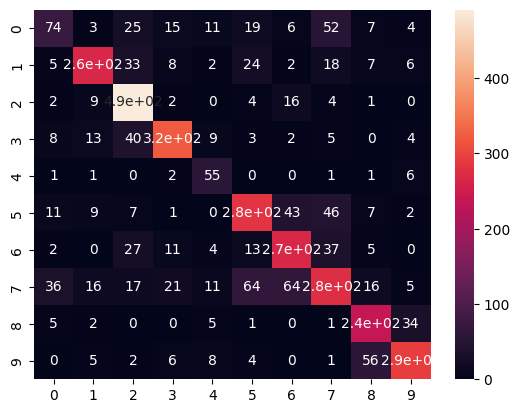

In [14]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
sns.heatmap(conf_matrix.cpu().numpy(),annot=True)